# Adaptive Sampling for High Throughput Experimentation 

## Part 2: Entering the Task Space


In **part 2** we'll embed teams in the larger "task space" that describes the charachteristics of tasks to be performed. We'll develop a hierarchical model that lets us learn the properties of the task space from samples taken in the team space.


In [1]:
# %pylab inline  # Make plots inline in the notebook
import numpy as np  # Import NumPy for numerical computations
import theano  # Import Theano for deep learning and numerical computations
import pandas as pd
from sklearn.cluster import KMeans
import pymc3 as pm  # Import PyMC3 for Bayesian statistical modeling
from pymc3.gp.util import plot_gp_dist  # Import Gaussian process plotting utility from PyMC3
from scipy.stats import ttest_ind  # Import independent samples t-test function from SciPy
import matplotlib.pyplot as plt

import warnings  # Import warnings module
# warnings.simplefilter(action="ignore", category=FutureWarning)  # Ignore FutureWarning warnings
# theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"  # Ignore certain compiler errors

import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['KaiTi', 'SimHei', 'FangSong']  # Chinese fonts, prioritize using KaiTi, if not available, then use SimHei
mpl.rcParams['font.size'] = 12  # Font size
mpl.rcParams['axes.unicode_minus'] = False  # Properly display negative signs

plt.rcParams.update({  # Update plot parameters
    'axes.spines.bottom': True,  # Show bottom axis
    'axes.spines.left': False,  # Hide left axis
    'axes.spines.right': False,  # Hide right axis
    'axes.spines.top': False  # Hide top axis
})


WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.


### Define a "ground truth" function

In this notebook, we'll continue to look at the coefficients of a linear regression over a two dimensional team space. However, instead of being fixed, these coefficients will be determined by a function over the task space. To make it easy to visualize, we'll look at a simple 1-D task space. Our goal is to estimate the functions $C_x(t)$ and $C_y(t)$ in the task space, by measuring specific teams $(x,y)$ performing specific tasks $(t)$.

Text(0.5, 1.0, '图1：任务空间中的系数')

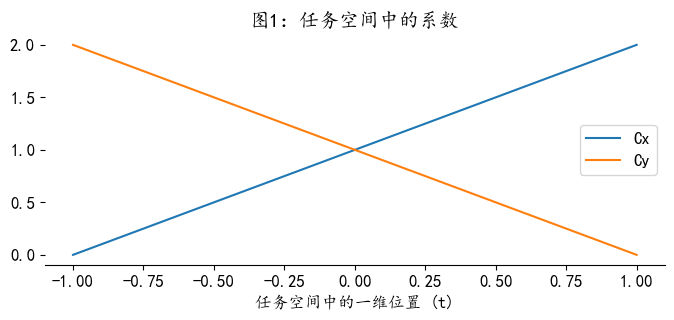

In [2]:
def measure_task(t):
    """
    Define the "true value" function in the task space
    """
    Cx = t + 1  # Calculate Cx
    Cy = -t + 1  # Calculate Cy
    b = 0  # Constant term b
    return Cx, Cy, b  # Return Cx, Cy, and b

tt = np.linspace(-1, 1, 100)  # Generate 100 evenly spaced points from -1 to 1
Cx, Cy, b = measure_task(tt)  # Calculate Cx, Cy, and b for these points

plt.figure(figsize=(8, 3))  # Create a figure of size 8x3
plt.plot(tt, Cx, label="Cx")  # Plot the curve of Cx changing with tt
plt.plot(tt, Cy, label="Cy")  # Plot the curve of Cy changing with tt
plt.xlabel("One-dimensional position in task space (t)")  # Set the x-axis label
plt.legend()  # Display the legend
plt.title("Figure 1: Coefficients in Task Space")  # Set the figure


As before, we measure the "ground truth" value of points in the team space, but the coefficients will come from the task's position in the task space. 

In [3]:
def ground_truth(x, y, t):
    """
    Define the world model we are trying to measure at team space point (x, y) and task space point 't'
    """
    Cx_t, Cy_t, b = measure_task(t)  # Get the coefficients at task space t
    z = Cx_t*x + Cy_t*y + b  # Calculate the "true" output value z
    return z  # Return z

def measure(x, y, t):
    """
    Conduct an experiment at team space point (x, y) and task space point 't' and return the result with measurement noise
    """
    #sigma = 1.5  # Very noisy measurement
    sigma = .5  # Somewhat noisy measurement
    
    z_measured = ground_truth(x, y, t) + np.random.normal(loc=0, scale=sigma, size=np.shape(x))  # Calculate the measurement value with noise
    return z_measured  # Return the measurement value

measure(x=1, y=1, t=1)  # Conduct a measurement at (x=1, y=1, t=1)


2.170225811579731

At any given point in the task space, this collapses to the familiar 2-D example from part 1:

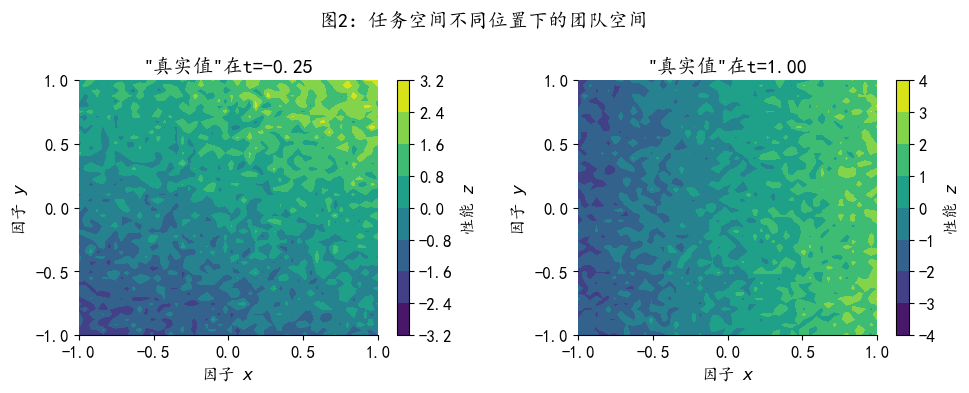

In [4]:
xx, yy = np.meshgrid(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50))  # Generate a grid of 50 evenly spaced points from -1 to 1

plt.figure(figsize=(10, 4))  # Create a figure of size 10x4

plt.subplot(1, 2, 1)  # Create a subplot layout with 1 row and 2 columns, and activate the 1st subplot
t = -.25  # Set the task space position t to -0.25
zz_observations = measure(xx, yy, t)  # Measure the results at t=-0.25 in the team space
plt.contourf(xx, yy, zz_observations)  # Draw the contour plot
plt.xlabel("Factor $x$")  # Set the x-axis label
plt.ylabel("Factor $y$")  # Set the y-axis label
plt.colorbar(label="Performance $z$")  # Display the color bar and set the label
plt.title('"True Value" at t=%.02f' % t)  # Set the subplot title

plt.subplot(1, 2, 2)  # Activate the 2nd subplot
t = 1  # Set the task space position t to 1
zz_observations = measure(xx, yy, t)  # Measure the results at t=1 in the team space
plt.contourf(xx, yy, zz_observations)  # Draw the contour plot
plt.xlabel("Factor $x$")  # Set the x-axis label
plt.ylabel("Factor $y$")  # Set the y-axis label
plt.colorbar(label="Performance $z$")  # Display the color bar and set the label
plt.title('"True Value" at t=%.02f' % t)  # Set the subplot title

plt.suptitle("Figure 2: Team Space at Different Positions in Task Space")  # Set the overall figure title
plt.tight_layout()  # Automatically adjust subplot parameters to give space for the title and labels


### Include the task space in our surrogate model

We construct a hierarchical model, with the team space represented as before as a 2-D linear function defined by coefficients $C_x$ and $C_y$. These coefficients are each represented using a gaussian process over the 1-D task space. 

The gaussian process is a nonparametric estimator, and can represent any function in the task space, given a kernel (here called a covariance function) with a given shape and width. The kernel determines how much of our knowledge at one point in the task space should be included in assessing other points in the task space. Here we use a squared exponential kernel, appropriate for smooth functions. 

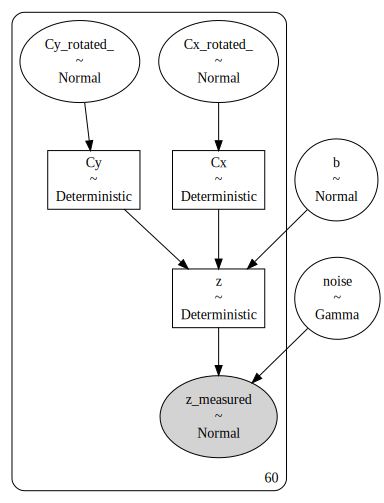

In [5]:
def build_model(x_sampled, y_sampled, t_sampled, z_observations, gp_length_scale=.4, noise_level=1e-6):
    n_samples = len(x_sampled)
    with pm.Model() as taskspace_hierarchical_model:
        # Add a small white noise term
        cov_func = pm.gp.cov.ExpQuad(1, ls=gp_length_scale) + pm.gp.cov.WhiteNoise(noise_level)

        gpx = pm.gp.Latent(cov_func=cov_func)
        gpy = pm.gp.Latent(cov_func=cov_func)

        Cx = gpx.prior("Cx", X=t_sampled[:, None], shape=n_samples)
        Cy = gpy.prior("Cy", X=t_sampled[:, None], shape=n_samples)

        b = pm.Normal("b", mu=0, sd=1)
        noise = pm.Gamma("noise", alpha=2, beta=1)

        z = pm.Deterministic("z", Cx * x_sampled + Cy * y_sampled + b)
        z_measured = pm.Normal("z_measured", mu=z, sd=noise, observed=z_observations)

    return taskspace_hierarchical_model, (gpx, gpy, b)

n_samples = 60  # Number of samples
xs, ys, ts = np.random.uniform(-1, 1, size=(3, n_samples))  # Generate random samples uniformly distributed in the range -1 to 1
z_observations = measure(xs, ys, ts)  # Measure observations at xs, ys, ts

taskspace_hierarchical_model, elements = build_model(xs, ys, ts, z_observations)  # Build the model
pm.model_to_graphviz(taskspace_hierarchical_model)  # Draw the model structure graph


As before, to fit the model, we run Markov Chain Monte Carlo (MCMC) to get a distribution over the parameters. In this case, rather than a distribution of point estimates for the coefficients, the MCMC returns a distribution of functions - the Gaussian Processes (GP).

In [6]:
with taskspace_hierarchical_model:
    trace = pm.sample(1000)


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
F:\miniconda3\envs\basic38\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, b, Cy_rotated_, Cx_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


### Define a new performance measure

The GP's present in our MCMC posterior are defined by the samples taken in our dataset, at particular locations in the task space. In order to determine their value at new points in the task space, we need to sample the GPs again at the new points, conditional on the data. To plot the GPs over the full task space, we'll sample them at regular intervals in the task space.

We also need to figure out how we're going to assess the current performance of our model. In part 1, when we were looking at a single location in the task space, we used the t-statistic to evaluate the performance of our model (remember that our objective was to determine the most influential coefficient, not necessarily to predict absolute performance in a location).

Now that the coefficients are represented as a function, we want to scale this performance measure over the whole space. We can plot the T statistic over the space, and in order to aggregate this to a single value, take the harmonic mean (So as to assess the ability of the coefficient functions to give a reasonable result across the task space, and not inflate the score with very strong separation at a single point).

F:\miniconda3\envs\basic38\lib\site-packages\pymc3\sampling.py:1714: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


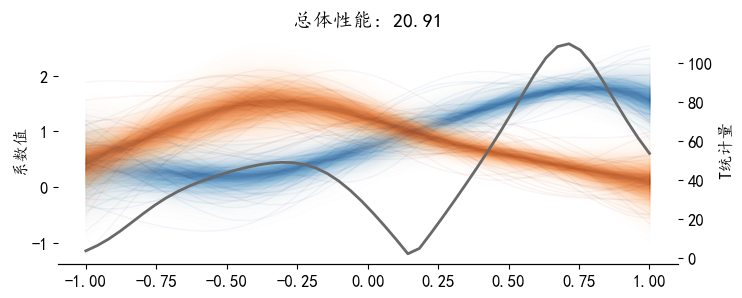

In [7]:
def draw_task_space(taskspace_hierarchical_model,
                    elements,
                    trace,
                    ax,
                    plot_t=np.linspace(-1, 1, 50)):
    """
    Draw the model results in the task space
    """
    gpx, gpy, b = elements  # Get model elements
    
    with taskspace_hierarchical_model:
        # Define posterior predictions in the task space
        Cx_plot = gpx.conditional("Cx_plot", plot_t[:, None])  # Conditional prediction for Cx_plot
        Cy_plot = gpy.conditional("Cy_plot", plot_t[:, None])  # Conditional prediction for Cy_plot
        # Resample the GP on new points in the task space, conditioned on existing data
        C_functions = pm.sample_posterior_predictive(
            trace,
            var_names=["Cx_plot", "Cy_plot"],
            samples=500)  # Sample 500 times from posterior predictive
        
    # Plot Cx
    plot_gp_dist(ax, C_functions["Cx_plot"], plot_t, 
                 palette="Blues", fill_alpha=.05, samples_alpha=.05)  # Plot GP distribution for Cx
    ax.plot([], [], 'cornflowerblue', alpha=1, linewidth=2, label="Cx")  # Legend placeholder
    
    # Plot Cy
    plot_gp_dist(ax, C_functions["Cy_plot"], plot_t, 
                 palette="Oranges", fill_alpha=.05, samples_alpha=.05)  # Plot GP distribution for Cy
    ax.plot([], [], 'darkorange', alpha=1, linewidth=2, label="Cy")  # Legend placeholder
    ax.set_ylabel("Coefficient value")  # Set y-axis label
    
    # Measure absolute t-statistics for all points
    t_statistics = np.array([np.abs(ttest_ind(C_functions['Cx_plot'][:, i], C_functions['Cy_plot'][:, i]).statistic) for i in range(len(plot_t))])  # Calculate t-statistics
    ax2 = ax.twinx()  # Create twin y-axis
    ax2.plot(plot_t, t_statistics, 'dimgrey', linewidth=2)  # Plot t-statistics
    ax2.set_ylabel("T-statistic")  # Set y-axis label
    ax.plot([], [], 'dimgrey', linewidth=2, label="T-statistic")  # Legend placeholder
    
    performance = 1/np.mean(1/t_statistics)  # Calculate performance
    ax.set_title("Overall performance: %.02f" % performance)  # Set title
    
    plt.xlabel("One-dimensional position in task space")  # Set x-axis label
    return C_functions  # Return GP functions

plt.figure(figsize=(8, 3))  # Create a figure of size 8x3
ax = plt.subplot(1, 1, 1)  
C_functions = draw_task_space(taskspace_hierarchical_model, elements, trace, ax=ax)  # Draw task space


### Define a new aquisition function
When we want to assess the benefit of taking a new sample at a given candidatate point in the task and team space, we need again to draw from the GPs conditional on the data. 

For now, we'll stick with an aquisition function that prioritizes minimizing the variance in the team space, as a heuristic for learning the functions of the coefficients across the task space. Later we'll explore alternate aquisition functions that manage this transition more directly.

In [8]:
def select_max_variance(taskspace_hierarchical_model, trace, 
                        candidate_xs, candidate_ys, candidate_ts,
                        elements):
    """
    Select the point with the maximum variance in the task space
    """
    gpx, gpy, b = elements  # Get model elements
    with taskspace_hierarchical_model:
        # Define posterior predictions in the task space
        Cx_candidates = gpx.conditional("Cx_candidates", candidate_ts[:, None])  # Conditional prediction for Cx candidates
        Cy_candidates = gpy.conditional("Cy_candidates", candidate_ts[:, None])  # Conditional prediction for Cy candidates
        # Given coefficient samples at positions in the task space, predict performance in the team space
        performance_pred = pm.Deterministic(
            "performance_pred",
            Cx_candidates * candidate_xs + Cy_candidates * candidate_ys + b
        )  # Deterministic prediction of performance
        predictions = pm.sample_posterior_predictive(trace, var_names=["performance_pred"], samples=500)  # Sample 500 times from posterior predictive
        
    # Calculate the score (variance) for each candidate sample point
    score = predictions['performance_pred'].var(axis=0)  # Calculate the score (variance)
    
    # Find the index of the candidate with the maximum variance
    choice_index = np.argmax(score)  # Select the index of the point with the maximum variance
    
    return candidate_xs[choice_index], candidate_ys[choice_index], candidate_ts[choice_index]  # Return the selected candidate point

n_candidates = 3  # Number of candidate points
candidate_xs, candidate_ys, candidate_ts = np.random.uniform(-1, 1, size=(3, n_candidates))  # Generate random candidate samples uniformly distributed in the range -1 to 1
print("Candidates:")  # Print candidate points
print('\n'.join([str(a) for a in zip(candidate_xs, candidate_ys, candidate_ts)]))  # Print candidate coordinates

selection = select_max_variance(taskspace_hierarchical_model, trace, 
                                candidate_xs, candidate_ys, candidate_ts, 
                                elements)  # Select the point with the maximum variance in the task space
print("Selected point:")  # Print selected point
selection  # Display selected point


候选点:
(-0.3241808364436847, 0.7665609532056679, -0.9472085801435013)
(-0.1680912106378043, -0.5027166640873688, 0.4830382575039831)
(0.7124939001306652, 0.7627126455474842, 0.9163716408573275)


选定点:


(0.7124939001306652, 0.7627126455474842, 0.9163716408573275)

In [9]:
def stratified_sampling(data, stratification_variable, n_samples_per_stratum):
    strata = data.groupby(stratification_variable, group_keys=False).apply(lambda x: x.sample(min(len(x), n_samples_per_stratum)))
    return strata

def randomize_experiment_groups(data):
    randomized_data = data.sample(frac=1).reset_index(drop=True)
    return randomized_data

## Active learning on the task space

Now we can put all the pieces together in our surrogate-predict-choose-sample loop. We see that as more data is incorporated in the model, our surrogate model approaches the underlying ground truth.

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
F:\miniconda3\envs\basic38\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, b, Cy_rotated_, Cx_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
F:\miniconda3\envs\basic38\lib\site-packages\pymc3\sampling.py:1714: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


ValueError: Input dimension mis-match. (input[0].shape[0] = 3, input[1].shape[0] = 2)

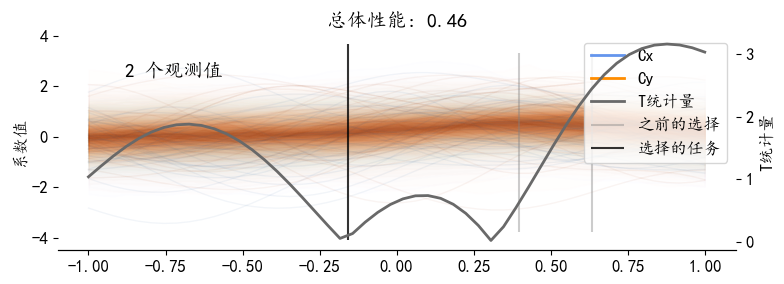

In [10]:
n_initial_samples = 2
xs, ys, ts = np.random.uniform(-1, 1, size=(3, n_initial_samples))
z_observations = measure(xs, ys, ts)

# Redesign the experiment, assuming the introduction of new features or re-bucketing
# Here we use an example assuming we re-bucket the variable 'ts'
data = pd.DataFrame({'xs': xs, 'ys': ys, 'ts': ts})
# Assuming we re-bucket ts into two new buckets
data['ts_binned'] = pd.cut(data['ts'], bins=2, labels=['Bucket1', 'Bucket2'])

# Stratified sampling
stratified_data = stratified_sampling(data, stratification_variable='ts_binned', n_samples_per_stratum=1)

# Randomize control and experimental groups
experiment_data = randomize_experiment_groups(stratified_data)

candidate_xs, candidate_ys, candidate_ts = np.meshgrid(
    np.linspace(-1, 1, 2),
    np.linspace(-1, 1, 2),
    np.linspace(-1, 1, 20),
)

# Main loop
n_iterations = 30
for i in range(n_iterations):
    xs = experiment_data['xs'].values
    ys = experiment_data['ys'].values
    ts = experiment_data['ts'].values

    taskspace_hierarchical_model, elements = build_model(xs, ys, ts, z_observations)
    with taskspace_hierarchical_model:
        trace = pm.sample(1000)

    selection = select_max_variance(taskspace_hierarchical_model, trace, candidate_xs.flatten(), candidate_ys.flatten(), candidate_ts.flatten(), elements)

    next_observation = measure(*selection)

    plt.figure(figsize=(8, 3))
    ax = plt.subplot(1, 1, 1)
    C_functions = draw_task_space(taskspace_hierarchical_model, elements, trace, ax=ax)
    ax.vlines(ts, *ax.get_ylim(), color='grey', label="Previous selections", alpha=.4)
    ax.vlines(selection[2], *ax.get_ylim(), color='k', label='Selected task', alpha=.8)
    plt.tight_layout()
    plt.annotate("%i observations" % len(z_observations), xy=(.1, .8), xycoords='axes fraction', fontsize=14)
    ax.legend(loc="upper right")

    xs = np.append(xs, selection[0])
    ys = np.append(ys, selection[1])
    ts = np.append(ts, selection[2])
    z_observations = np.append(z_observations, next_observation)

    # Update experimental data, for example, re-bucketing and redesigning the experiment in real scenarios
    # Here simplified as randomizing control and experimental groups
    experiment_data = randomize_experiment_groups(stratified_data)

plt.show()


### Takeaways:

1. A simple aquisition function (minimize the variance in the team space) does a reasonable job of estimating the coefficient functions in the task space. 
2. We are able to infer the coefficients a given point in the task space with relatively few samples, because of the hierarchical model. The hierarchical model depends on having a consistent way to assess performance across locations in the task space, so we'll need to see if we can actually implement this in reality.
2. The T-statistic function is still very uneven, meaning that better aquisition functions are likely possible.
3. The performance measure used here is very noisy, probably due to sampling error in the MCMC process. But, we may still find better performance measures.



### About this notebook

In [ ]:
# which python version are we using?
!python --version

In [ ]:
# which version of the libraries are we using?
import scipy
import itertools
print('\n'.join(f'{m.__name__} {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

In [28]:
import numpy as np
import pymc3 as pm

def build_model(x_sampled, y_sampled, t_sampled, z_observations, gp_length_scale=1.0, noise_level=1.0):
    taskspace_hierarchical_model = pm.Model()

    with taskspace_hierarchical_model:
        # Priors
        Cx = pm.Normal("Cx", mu=0, sigma=1)
        Cy = pm.Normal("Cy", mu=0, sigma=1)
        b = pm.Normal("b", mu=0, sigma=1)
        
        # Model
        noise = pm.Gamma("noise", alpha=2, beta=1)
        
        # Ensure dimensions match
        assert x_sampled.shape[0] == y_sampled.shape[0] == z_observations.shape[0], "Dimensions mismatch!"
        
        z = pm.Deterministic("z", Cx * x_sampled + Cy * y_sampled + b)
        
        z_measured = pm.Normal("z_measured", mu=z, sd=noise, observed=z_observations)
        
    return taskspace_hierarchical_model

# Example usage
xs = np.array([0.1, 0.2, 0.3])
ys = np.array([0.2, 0.3, 0.4])
ts = np.array([0.5, 0.6, 0.7])
z_observations = np.array([1.1, 1.2, 1.3])

# Call build_model function
model = build_model(xs, ys, ts, z_observations)

# Sample using PyMC3
with model:
    trace = pm.sample(1000)


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
F:\miniconda3\envs\basic38\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, b, Cy, Cx]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
There were 170 divergences after tuning. Increase `target_accept` or reparameterize.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7134960710409948, but should be close to 0.8. Try to increase the number of tuning steps.
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
